📤 Select an image file to upload (PNG/JPG/BMP, etc.)...


Saving image.png to image.png
✅ Uploaded: image.png


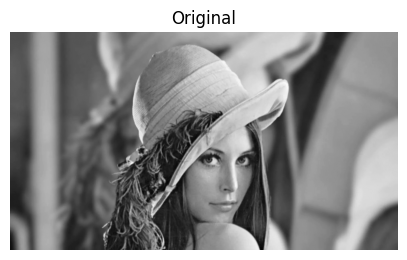

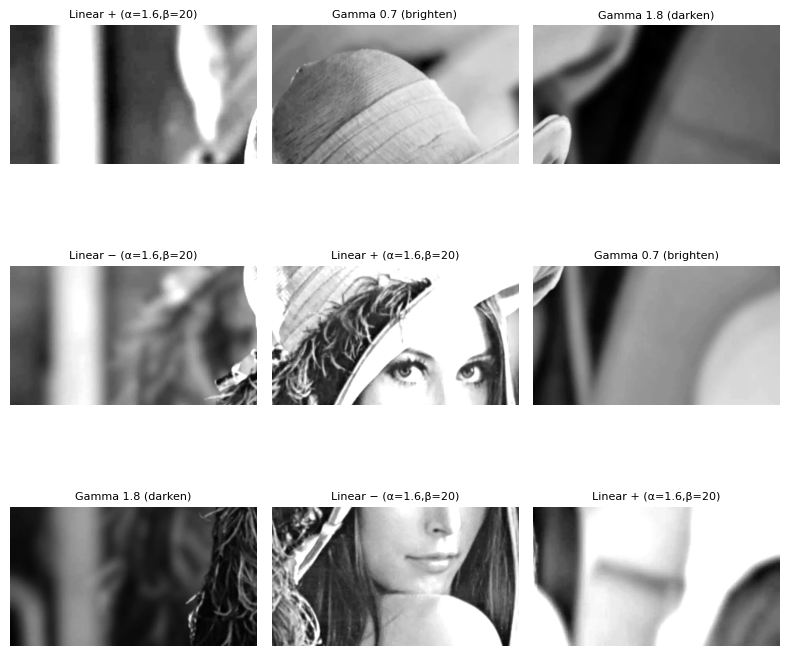

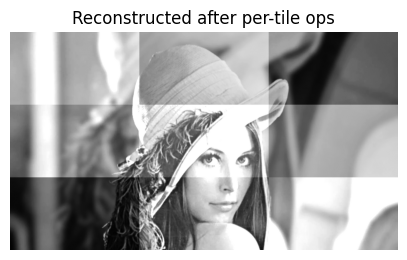

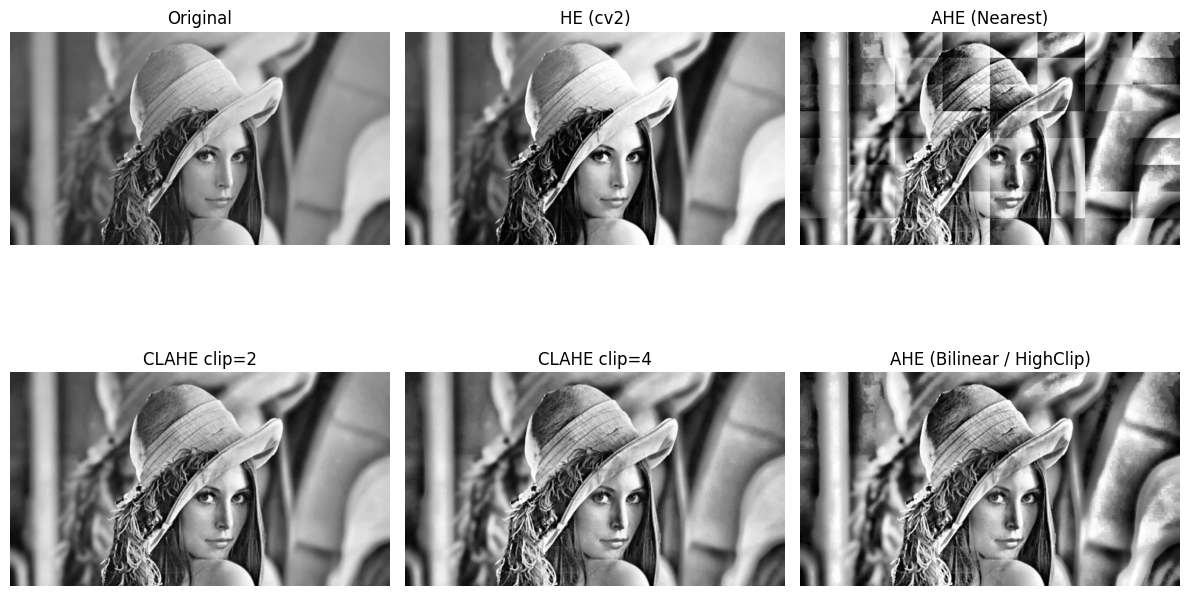

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


def linear_operation1(img, alpha=1.5, beta=25):
    new_img = alpha * img.astype(np.float32) + beta
    return np.clip(new_img, 0, 255).astype(np.uint8)

def linear_operation2(img, alpha=1.5, beta=25):
    new_img = alpha * img.astype(np.float32) - beta
    return np.clip(new_img, 0, 255).astype(np.uint8)


def gamma_operation1(img, gamma=0.6):
    norm = img.astype(np.float32) / 255.0
    corrected = np.power(norm, float(gamma))
    return np.clip(corrected * 255.0, 0, 255).astype(np.uint8)

def gamma_operation2(img, gamma=1.8):
    norm = img.astype(np.float32) / 255.0
    corrected = np.power(norm, float(gamma))
    return np.clip(corrected * 255.0, 0, 255).astype(np.uint8)


def divide_image(img, s):
    h, w = img.shape
    ph, pw = h // s, w // s
    img_c = img[:ph * s, :pw * s]
    parts = []
    for i in range(s):
        for j in range(s):
            y1, y2 = i * ph, (i + 1) * ph
            x1, x2 = j * pw, (j + 1) * pw
            parts.append(img_c[y1:y2, x1:x2])
    return parts, ph, pw

def combine_image(parts, s, ph, pw):
    out = np.zeros((s * ph, s * pw), dtype=np.uint8)
    k = 0
    for i in range(s):
        for j in range(s):
            y1, y2 = i * ph, (i + 1) * ph
            x1, x2 = j * pw, (j + 1) * pw
            out[y1:y2, x1:x2] = parts[k]
            k += 1
    return out

def HE(img):
    return cv2.equalizeHist(img)

def AHE_nearest(img, tiles=(8, 8)):
    H, W = img.shape
    ny, nx = tiles
    th, tw = H // ny, W // nx
    out = np.zeros_like(img)
    for i in range(ny):
        for j in range(nx):
            y0, y1 = i * th, (i + 1) * th if i < ny - 1 else H
            x0, x1 = j * tw, (j + 1) * tw if j < nx - 1 else W
            tile = img[y0:y1, x0:x1]
            out[y0:y1, x0:x1] = cv2.equalizeHist(tile)
    return out

def CLAHE(img, clip=2.0, tile_grid=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=float(clip),
                            tileGridSize=(int(tile_grid[1]), int(tile_grid[0])))
    return clahe.apply(img)

def AHE_bilinear(img, tile_grid=(8, 8)):

    return CLAHE(img, clip=40.0, tile_grid=tile_grid)


def load_image_colab_or_path(default_path="image.png"):

    try:

        from google.colab import files
        print("📤 Select an image file to upload (PNG/JPG/BMP, etc.)...")
        uploaded = files.upload()
        if not uploaded:
            raise FileNotFoundError("No file uploaded.")

        img_name = list(uploaded.keys())[0]
        print(f"✅ Uploaded: {img_name}")
        return img_name
    except Exception:
        return default_path

# ----------------------------- Main ---------------------------------- #
def main():

    img_path = load_image_colab_or_path("image.png")

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image not found or unreadable: {img_path}")

    s = 3
    parts, ph, pw = divide_image(img, s)

    processed, op_names = [], []
    for i, p in enumerate(parts):
        m = i % 4
        if m == 0:
            out = linear_operation1(p, alpha=1.6, beta=20)
            name = "Linear + (α=1.6,β=20)"
        elif m == 1:
            out = gamma_operation1(p, gamma=0.7)
            name = "Gamma 0.7 (brighten)"
        elif m == 2:
            out = gamma_operation2(p, gamma=1.8)
            name = "Gamma 1.8 (darken)"
        else:
            out = linear_operation2(p, alpha=1.6, beta=20)
            name = "Linear − (α=1.6,β=20)"
        processed.append(out)
        op_names.append(name)

    combined = combine_image(processed, s, ph, pw)

    he_img   = HE(img)
    ahe_near = AHE_nearest(img, tiles=(8, 8))
    clahe2   = CLAHE(img, clip=2.0, tile_grid=(8, 8))
    clahe4   = CLAHE(img, clip=4.0, tile_grid=(8, 8))
    ahe_bi   = AHE_bilinear(img, tile_grid=(8, 8))



    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray'); plt.title("Original"); plt.axis('off')
    plt.show()

    plt.figure(figsize=(8, 8))
    for idx, tile in enumerate(processed):
        plt.subplot(s, s, idx + 1)
        plt.imshow(tile, cmap='gray')
        plt.title(op_names[idx], fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(5, 5))
    plt.imshow(combined, cmap='gray')
    plt.title("Reconstructed after per-tile ops")
    plt.axis('off')
    plt.show()


    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.imshow(img, cmap='gray')
    plt.title('Original')
    plt.axis('off')


    plt.subplot(232)
    plt.imshow(he_img, cmap='gray')
    plt.title('HE (cv2)')
    plt.axis('off')

    plt.subplot(233)
    plt.imshow(ahe_near, cmap='gray')
    plt.title('AHE (Nearest)')
    plt.axis('off')

    plt.subplot(234)
    plt.imshow(clahe2, cmap='gray')
    plt.title('CLAHE clip=2')
    plt.axis('off')

    plt.subplot(235)
    plt.imshow(clahe4, cmap='gray')
    plt.title('CLAHE clip=4')
    plt.axis('off')

    plt.subplot(236)
    plt.imshow(ahe_bi, cmap='gray')
    plt.title('AHE (Bilinear / HighClip)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
